In [1]:
import HARK.ConsumptionSaving.ConsPortfolioModel as cpm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import sys

sys.path.append('.')

import hark_portfolio_agents as hpa

## How to use this code


### Initialize the agents to start

This is to set up the agent parameters and quantities used in the simulation.

In [3]:
## List of tuples: 
##  ( parameters, (i.e. coefficient of relative risk aversion CRRA)
##    number of agents represented,
##    ( initial risky percent, $$$ in risky asset, $$$ in riskless asset)
agent_classes = [
    ({'CRRA': 5.0}, 100, (0.08, 800, 9200)), # Normal consumers
    ({'CRRA': 6.0}, 50,  (0.08, 800, 9200)),  # More risk-averse consumers
    ({'CRRA': 4.0}, 50,  (0.08, 800, 9200))  #  Less risk-averse consumers
]


### parameters shared by all agents
ap = {
    'AdjustPrb' : 0.0, # probabability of rebalancing during simulation
    'aNrmInitMean' : 1.0, # initial distribution of assets held
    'aNrmInitStd' : 0.0,
    'pLvlInitMean' : 1.0, # initial distribution of permanent income
    'pLvlInitStd' : 0.0
}

In [4]:
agents = hpa.create_agents(agent_classes, ap)

In [5]:
agents[0].mNrmNow

array([3.68507648, 3.68507648, 3.78585464, 4.01767823, 3.57158639,
       3.68507648, 4.01767823, 3.68507648, 3.57158639, 3.89036951,
       3.89036951, 3.78585464, 3.57158639, 3.78585464, 3.57158639,
       3.89036951, 3.78585464, 4.01767823, 4.25965532, 3.89036951,
       4.25965532, 4.01767823, 3.89036951, 3.57158639, 4.25965532,
       3.37662426, 3.37662426, 3.37662426, 4.01767823, 3.78585464,
       3.37662426, 4.01767823, 3.37662426, 3.68507648, 3.68507648,
       3.89036951, 3.89036951, 3.89036951, 3.57158639, 3.68507648,
       4.01767823, 4.25965532, 3.57158639, 3.68507648, 3.89036951,
       3.68507648, 3.37662426, 3.89036951, 3.78585464, 3.57158639,
       3.68507648, 4.25965532, 3.68507648, 4.01767823, 3.37662426,
       3.37662426, 3.78585464, 3.68507648, 3.78585464, 4.25965532,
       3.89036951, 4.01767823, 3.78585464, 3.68507648, 4.25965532,
       3.68507648, 3.68507648, 3.89036951, 3.68507648, 4.01767823,
       4.01767823, 3.89036951, 4.25965532, 3.78585464, 4.25965

#### Test agent

This is a test agent used to test and demonstrate the functions below.

In [6]:
# test agent
agent = cpm.PortfolioConsumerType(
    AgentCount = 3,
    **ap
)
agent.solve()
agent.T_sim = 100
agent.track_vars += ['pLvlNow','mNrmNow','ShareNow','RiskyNow']
agent.initializeSim()
agent.simulate()

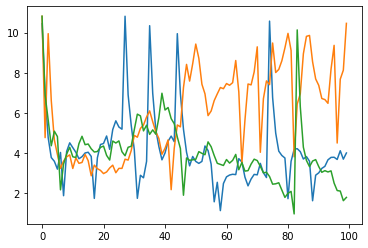

In [7]:
plt.plot(agent.history['mNrmNow'] * agent.history['pLvlNow'])

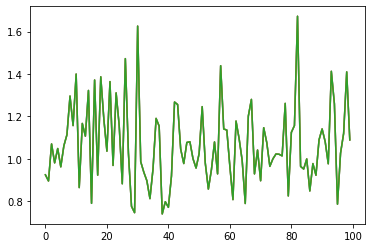

In [8]:
plt.plot(agent.history['RiskyNow'])

The normalize market assets of each agent at the current (final) stage of the simulation.

The function from normalized market assets to the proportion of assets allocated to the risky share.

### Synthetic price data

In the future, get this from the LiquidityModel.

For now, just use any array of prices with noise and drift.

In [9]:
return_rate = .05
time_steps = 1000

def random_prices(return_rate = return_rate, time_steps = time_steps):
    prices = np.random.random(
        time_steps
    ) + np.arange(0,
                  return_rate,return_rate / time_steps)
    
    return prices

In [10]:
## This is a dummy method that the ABM group
## needs to write to connect to the NetLogo
## model.

def run_market(buy_sell):
    return random_prices()

### Agents estimate return rate and volatility from historical data

The agents look at the most recent historical price data to form their expectations of the future.

This is a very simplified version of what could later be better specified in line with _adaptive expectations_:

https://en.wikipedia.org/wiki/Adaptive_expectations

### Demand function for the intermittent demand problem

In the intermittent demand problem, consumers take their current state and determine risky porfolio share of their assets to invest.

The agent responds to the price history by:
 - updating their current assets
 - updating their expectations of the risky asset
 - returning their risky share allocation.

Other aspects of the problem are fixed for now.

### Putting it all together

Each agent knows their old risky allocation, old risk free allocation, and the prices of the last quarter.

They computer their new market assets and then their new demand.

In [11]:
## List of tuples: 
##  ( parameters, (i.e. coefficient of relative risk aversion CRRA)
##    number of agents represented,
##    ( initial risky percent, $$$ in risky asset, $$$ in riskless asset)
agent_classes = [
    ({'CRRA': 5.0}, 100, (0.08, 800, 9200)), # Normal consumers
    ({'CRRA': 6.0}, 50,  (0.08, 800, 9200)),  # More risk-averse consumers
    ({'CRRA': 4.0}, 50,  (0.08, 800, 9200))  #  Less risk-averse consumers
]


### parameters shared by all agents
ap = {
    'aNrmInitMean' : 1.0, # initial distribution of assets held
    'aNrmInitStd' : 0.0,
    'pLvlInitMean' : 1.0, # initial distribution of permanent income
    'pLvlInitStd' : 0.0
}

# STEP 1. Initialize the agents. (and the market?)

agents = hpa.create_agents(agent_classes, ap)


# STEP 2. Create starting demand for the market.
#         Burn in the new prices.

# The initial demands for each agent
# hpa.init_prices is used to set the agent's starting
# beliefs about the price process.
init_demands = hpa.demands(agents, hpa.init_prices)

buy_sell = hpa.aggregate_buy_and_sell(
    hpa.no_demand(agents), # zero allocated to risky asset
    init_demands
)

## TODO: ABM Group reimplement the run_market method
prices = run_market(buy_sell)
old_demands = init_demands

# STEP 3. Run simulation for N rebalances

N = 10

for i in range(N):

    # simulate one period on the macro side
    hpa.simulate(agents, 1)
    new_demands = hpa.demands(agents, prices)
    
    buy_sell = hpa.aggregate_buy_and_sell(
        old_demands,
        new_demands
    )
    
    prices = run_market(buy_sell)
    old_demands = new_demands

Getting risky asset demand for all agents
computing aggregate buy/sell orders
simulating macro agents
Getting risky asset demand for all agents
computing aggregate buy/sell orders
simulating macro agents
Getting risky asset demand for all agents
computing aggregate buy/sell orders
simulating macro agents
Getting risky asset demand for all agents
computing aggregate buy/sell orders
simulating macro agents
Getting risky asset demand for all agents
computing aggregate buy/sell orders
simulating macro agents
Getting risky asset demand for all agents
computing aggregate buy/sell orders
simulating macro agents
Getting risky asset demand for all agents
computing aggregate buy/sell orders
simulating macro agents
Getting risky asset demand for all agents
computing aggregate buy/sell orders
simulating macro agents
Getting risky asset demand for all agents
computing aggregate buy/sell orders
simulating macro agents
Getting risky asset demand for all agents
computing aggregate buy/sell orders
simu